In [1]:
import os
import sys
import random 
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

NOTEBOOK_DIR = os.getcwd()
ROOT_DIR = os.path.dirname(NOTEBOOK_DIR)
MODEL_DIR = os.path.join(ROOT_DIR, "models")
sys.path.append(ROOT_DIR)

from models.attention_mil import MILSigmoid, MILAttention
INPUT_SHAPE = (28, 28, 1)

c:\Users\4pygm\miniconda3\envs\breast\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mnist_dataset = tfds.as_numpy(tfds.load('mnist', batch_size=-1, as_supervised=True))

In [3]:
x_train, y_train = mnist_dataset['train']
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)
x_test, y_test = mnist_dataset['test']

In [4]:
class Sampler:
    def __init__(self, x_train, y_train, max_bag_size=20):
        self.x_train = x_train
        self.y_train = y_train
        self.max_bag_size = 20
        self.population = set(range(len(x_train)))

    def get_instance_index(self, k):
        return_instance_indices = random.sample(self.population, k=k)

        self.population -= set(return_instance_indices)

        return np.asarray(return_instance_indices)

    def build_bags(self):
        x_bags = list()
        y_bags = list()
        total_instance = 0
        while total_instance <= len(self.x_train)-self.max_bag_size:
            n_instances = random.randint(5, self.max_bag_size)
            total_instance += n_instances

            indices = sampler.get_instance_index(n_instances)
            label = 1 in set(y_train[indices]) # or 7 in set(y_train[indices])
            
            x_bags.append(np.stack(x_train[indices], axis=0))
            y_bags.append(label)   

        return x_bags, y_bags

sampler = Sampler(x_train, y_train)
train_bag_x, train_bag_y = sampler.build_bags()

sampler = Sampler(x_val, y_val)
val_bag_x, val_bag_y = sampler.build_bags()

sampler = Sampler(x_test, y_test)
test_bag_x, test_bag_y = sampler.build_bags()

len(train_bag_x), np.asarray(train_bag_y).sum()
print("expected non trainable acc:", np.asarray(train_bag_y).sum() / len(train_bag_x) * 100)

expected non trainable acc: 73.60265633646928


In [5]:
def data_generate(train_bag_x, train_bag_y):
    while True:
        for bag_x, label in zip(train_bag_x, train_bag_y):
            instance_tensors = tf.convert_to_tensor(bag_x, dtype=tf.float32)
            label_tensor = tf.convert_to_tensor([[label]], dtype=tf.float32)
            
            yield instance_tensors, label_tensor

train_generator = data_generate(train_bag_x, train_bag_y)
val_generator = data_generate(val_bag_x, val_bag_y)
test_generator = data_generate(test_bag_x, test_bag_y)

In [6]:
inputs = tf.keras.layers.Input(shape=(INPUT_SHAPE))
x = tf.keras.layers.Conv2D(3, kernel_size=3, strides=2)(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=3)(x)
x = tf.keras.layers.Conv2D(1, kernel_size=2, strides=1)(x)
x = tf.keras.layers.Conv2D(1, kernel_size=2, strides=1)(x)
x = tf.keras.layers.Flatten()(x)
alpha = MILAttention(L_dim=4, output_dim=1, use_gated=True)(x)
x = tf.keras.layers.multiply([alpha, x])
output = MILSigmoid(output_dim=1)(x)

model = tf.keras.models.Model(inputs=inputs, outputs=output)
model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 13, 13, 3)    30          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 4, 4, 3)      0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 3, 3, 1)      13          ['max_pooling2d[0][0]']          
                                                                                              

In [7]:
os.makedirs("check_points", exist_ok=True)
model_name = (
        "check_points/"
        + "mnist_mil_"
        + "acc({accuracy:.4f})_"
        + "epoch({epoch})_"
        + "val_loss({val_loss:.4f}).hd5"
    )

check_point = tf.keras.callbacks.ModelCheckpoint(
    model_name,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,  # (=decay)
    verbose=True,
)
callbacks = [check_point, early_stopping, reduce_lr]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks,
    steps_per_epoch=len(train_bag_x),
    validation_steps=len(val_bag_x),
)

Epoch 1/100
3605/3614 [============================>.] - ETA: 0s - loss: 0.6299 - accuracy: 0.7237
Epoch 1: val_loss improved from inf to 0.41457, saving model to check_points\mnist_mil_acc(0.7241)_epoch(1)_val_loss(0.4146).hd5
3614/3614 [==============================] - 10s 3ms/step - loss: 0.6291 - accuracy: 0.7241 - val_loss: 0.4146 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 2/100
3602/3614 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.8962
Epoch 2: val_loss improved from 0.41457 to 0.24046, saving model to check_points\mnist_mil_acc(0.8962)_epoch(2)_val_loss(0.2405).hd5
3614/3614 [==============================] - 9s 3ms/step - loss: 0.3030 - accuracy: 0.8962 - val_loss: 0.2405 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 3/100
3595/3614 [============================>.] - ETA: 0s - loss: 0.2360 - accuracy: 0.9305
Epoch 3: val_loss improved from 0.24046 to 0.19623, saving model to check_points\mnist_mil_acc(0.9308)_epoch(3)_val_loss(0.1962).hd5
3614/3614 [====

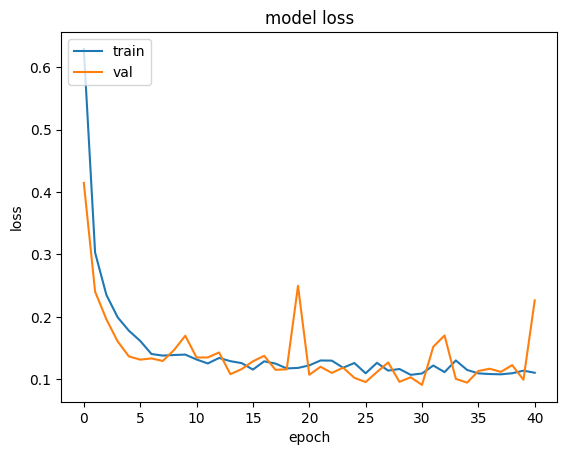

In [8]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

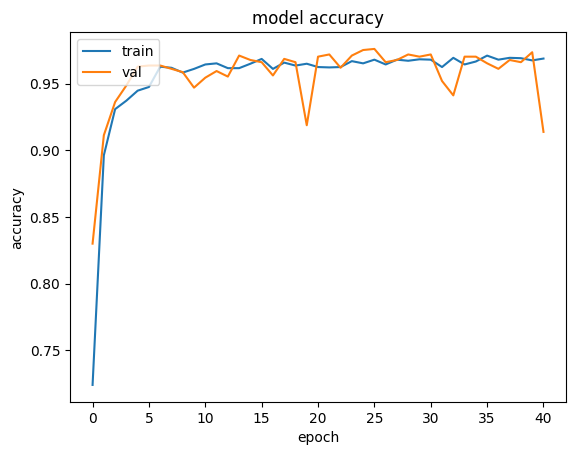

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
attention_subgraph = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer("mil_attention").output)

tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.95127857]], shape=(1, 1), dtype=float32)


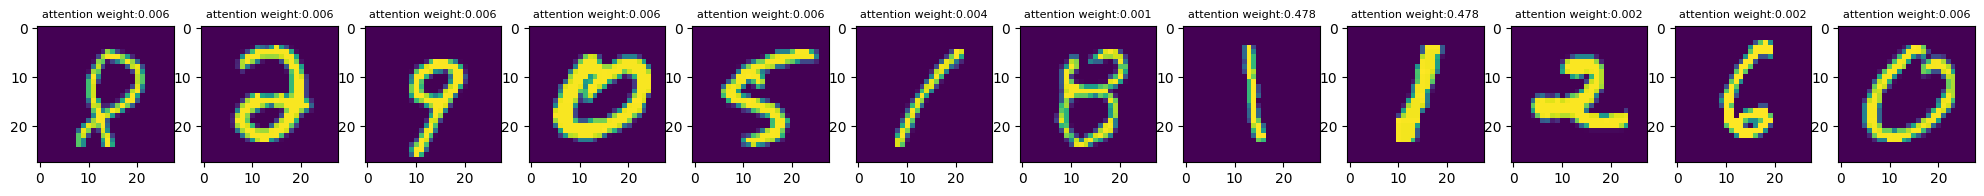

In [53]:
bag, label = next(test_generator)
print(label)
y_hat = model(bag)
attention = attention_subgraph(bag)
print(y_hat)
# print(attention)
fig = plt.figure(figsize=(25, 10))

for idx, instance in enumerate(bag, 1):
    plt.subplot(1, len(bag), idx)
    plt.title(f"attention weight:{round(float(attention[idx-1]), 3)}", fontdict={"size":8})
    plt.imshow(instance.numpy().reshape(28, 28) * attention[idx-1])